In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision import datasets
from torch.utils.data import DataLoader

import numpy as np
from tqdm import tqdm

import os
from PIL import Image

import matplotlib.pyplot as plt 

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device being used:", device)

if torch.cuda.is_available():
    print("CUDA is available!")
    print("GPU Device Name:", torch.cuda.get_device_name(0))
    print("Total GPU Count:", torch.cuda.device_count())
else:
    print("CUDA is not available, using CPU")

Device being used: cuda
CUDA is available!
GPU Device Name: NVIDIA GeForce RTX 3050 Laptop GPU
Total GPU Count: 1


In [1]:
!pip install wandb
import wandb
wandb.login()
wandb.require("core")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: beehappy2554 (beehappy2554-bosch-global) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: WARNING `wandb.require('core')` is redundant as it is now the default behavior.


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

base_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  # Horizontal flip
    transforms.RandomVerticalFlip(p=0.3),    # Vertical flip
    transforms.RandomRotation(90),           # Rotate between -15° to 15°
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.25)),  # Slight translation, no rotation here
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2, hue=0.2),  # Mild color adjustments
    transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0)),  # Light blur
    transforms.ToTensor(),  # Convert to tensor
])

# preparing dataset

In [3]:
# setup init

# run = wandb.init(
#     project="minialexnet",
#     config=config,
# )

run = wandb.init(
    project="hutech_mushroom",
    job_type="update_artifact",)

* add data to Artifacts

In [4]:
DATA_DIR ="../data"
artifact_data = wandb.Artifact("hutech-dataset", type="dataset")
artifact_data.add_dir(DATA_DIR)
run.log_artifact(artifact_data)

wandb: Adding directory to artifact (./../data)... Done. 1.4s


<Artifact hutech-dataset>

# Versioning the Dataset

In [28]:
### OPTIMIZE THIS
config = {
    "lr": 10e-5,
    "num_epochs": 100,
    "batch_size": 32, 
    "optimizer": "adam",
    "weight_decay": 0.0001,
    "momentum": 0.9
}

run = wandb.init(
    project="hutech_mushroom",
    job_type="train",
)

run.config.update(config, allow_val_change=True)
artifact_data = run.use_artifact('beehappy2554-bosch-global/hutech_mushroom/hutech-dataset:latest', type='dataset')
artifact_data_dir = artifact_data.download()

wandb:   1203 of 1203 files downloaded.  


In [29]:
run.config

{'lr': 0.0001, 'num_epochs': 100, 'batch_size': 32, 'optimizer': 'adam', 'weight_decay': 0.0001, 'momentum': 0.9}

## Fit into model

In [30]:
# Load datasets
BATCH_SIZE = run.config.batch_size
train_dataset = datasets.ImageFolder(root=os.path.join(artifact_data_dir, "train"), transform=base_transforms)
val_dataset = datasets.ImageFolder(root=os.path.join(artifact_data_dir, "val"), transform=base_transforms)
test_dataset = datasets.ImageFolder(root=os.path.join(artifact_data_dir, "test"), transform=base_transforms)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Get class labels
class_names = train_dataset.classes
print(f"Classes: {class_names}")

Classes: ['0', '1', '2', '3']


In [31]:
class MiniAlexNet(nn.Module):
    def __init__(self, num_classes=2):
        super(MiniAlexNet, self).__init__()
        
        # Convolutional Layer 1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=11, stride=4, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2)

        # Convolutional Layer 2
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)

        # Convolutional Layer 3 (Sửa lại)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=256, kernel_size=3, stride=2, padding=1)  # Giữ kernel size 3, stride 2
        self.bn3 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.gp = nn.AdaptiveAvgPool2d((6, 6))  # Giữ lại AdaptiveAvgPool2d
        # Fully Connected Layers with Dropout
        self.fc1 = nn.Linear(256 * 6 * 6, 512)  # Điều chỉnh theo kích thước đầu vào
        self.dropout1 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(512, 256)
        self.dropout2 = nn.Dropout(p=0.5)
        self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = self.gp(x)
        # Flatten the output from the convolutional layers
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

# Initialize model
num_classes = len(class_names)
model = MiniAlexNet(num_classes)
print(model)

MiniAlexNet(
  (conv1): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (gp): AdaptiveAvgPool2d(output_size=(6, 6))
  (fc1): Linear(in_features=9216, out_features=512, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=256, out_features=4, bias=T

In [32]:
from torchinfo import summary
summary(model, input_size=(1, 3, 227, 227))

Layer (type:depth-idx)                   Output Shape              Param #
MiniAlexNet                              [1, 4]                    --
├─Conv2d: 1-1                            [1, 64, 55, 55]           23,296
├─BatchNorm2d: 1-2                       [1, 64, 55, 55]           128
├─MaxPool2d: 1-3                         [1, 64, 27, 27]           --
├─Conv2d: 1-4                            [1, 32, 27, 27]           18,464
├─BatchNorm2d: 1-5                       [1, 32, 27, 27]           64
├─Conv2d: 1-6                            [1, 256, 14, 14]          73,984
├─BatchNorm2d: 1-7                       [1, 256, 14, 14]          512
├─MaxPool2d: 1-8                         [1, 256, 6, 6]            --
├─AdaptiveAvgPool2d: 1-9                 [1, 256, 6, 6]            --
├─Linear: 1-10                           [1, 512]                  4,719,104
├─Dropout: 1-11                          [1, 512]                  --
├─Linear: 1-12                           [1, 256]               

In [ ]:
def plot_one_batch(loader, batch_size=4):
    images, labels = next(iter(loader))
    # de-normalize images

    print(f"Batch size: {batch_size}")   

    rows = (batch_size + 3) // 4  
    fig, axes = plt.subplots(rows, 4, figsize=(10, 5))
    axes = axes.flatten()  
    
    for i in range(batch_size):
        img = images[i].permute(1, 2, 0)  # convert back to image
        label = labels[i]

        axes[i].imshow(img)
        axes[i].set_title(class_names[label], fontsize=10, pad=10)  
        axes[i].axis("off")

    for j in range(batch_size, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()  # Điều chỉnh layout để tránh chồng chữ lên ảnh
    plt.savefig("sample_batch.png", dpi=300, bbox_inches='tight')


Batch size: 32


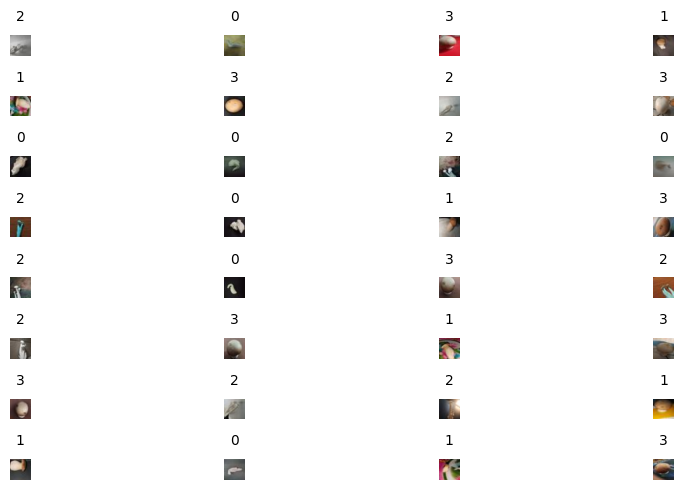

In [34]:
plot_one_batch(train_loader, BATCH_SIZE)
print(train_loader)

In [35]:
import time
def save_log(text, timestamp):
    # check if log file exists
    log_dir = "../log"
    with open(os.path.join(log_dir, f"training-alexnet-{timestamp}.log"), "w") as f:
        f.write(text + "\n")
    print(text)

In [36]:
print(len(train_dataset))
print(len(train_loader))
len(train_loader.dataset)

720
23


720

In [37]:
import torch.optim as optim
model = model.to(device)
wandb.watch(model, log="all", log_freq=100)
# Hyperparameters
NUM_EPOCHS = wandb.config.num_epochs
LEARNING_RATE = wandb.config.lr
BATCH_SIZE = wandb.config.batch_size
OPTIMIZER_NAME = wandb.config.optimizer
WEIGHT_DECAY = wandb.config.weight_decay
MOMENTUM = wandb.config.momentum

# optimize for only classifier layers
criterion = nn.CrossEntropyLoss()
if OPTIMIZER_NAME == "adam":
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
elif OPTIMIZER_NAME == "sgd":
    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY, momentum=MOMENTUM)
elif OPTIMIZER_NAME == "adamw":
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
else:
    raise ValueError(f"Invalid optimizer name: {OPTIMIZER_NAME}")
NUM_CLASSES = 2

train_losses = []
val_losses = []
timestamp = time.strftime("%Y-%m-%d %H:%M:%S")

# Stat check
print("Training model...")
print(f"Device: {device}")
print(f"Number of epochs: {NUM_EPOCHS}")
print(f"Optimizer: {optimizer}")
print(f"Criterion: {criterion}")
print(f"Dataset: {len(train_dataset)} training samples, {len(val_dataset)} validation samples")

# Training loop
for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    
    for inputs, labels in tqdm(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)

    # Validation phase: turn on eval mode, no gradient compute
    model.eval()
    val_running_loss = 0.0
    val_running_corrects = 0
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            val_running_corrects += torch.sum(preds == labels.data)

    val_loss = val_running_loss / len(val_dataset)
    val_acc = val_running_corrects.double() / len(val_dataset)
    print(f"[Epoch {epoch+1}/{NUM_EPOCHS}] Train Loss: {epoch_loss:.4f} Val Loss: {val_loss:.4f} Train Acc: {epoch_acc:.4f} Val Acc: {val_acc:.4f}")
    run.log({"train_loss": epoch_loss, "val_loss": val_loss, "train_acc": epoch_acc, "val_acc": val_acc})
    train_losses.append(epoch_loss)
    val_losses.append(val_loss)

# Save model
model_dir = "../models"
os.makedirs(model_dir, exist_ok=True)
model_path = os.path.join(model_dir, f"minialexnet-{timestamp}.pt")
torch.save(model.state_dict(), model_path)
print(f"Model saved at {model_path}")

# Save model as artifact
artifact_model = wandb.Artifact("minialexnet-model", type="model")
artifact_model.add_file(model_path)
run.log_artifact(artifact_model)

Training model...
Device: cuda
Number of epochs: 100
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0.0001
)
Criterion: CrossEntropyLoss()
Dataset: 720 training samples, 120 validation samples


100%|██████████| 4/4 [00:00<00:00,  9.33it/s]


[Epoch 1/100] Train Loss: 1.2789 Val Loss: 1.2965 Train Acc: 0.4167 Val Acc: 0.6000


100%|██████████| 4/4 [00:00<00:00,  8.96it/s]


[Epoch 2/100] Train Loss: 0.8884 Val Loss: 0.9019 Train Acc: 0.6528 Val Acc: 0.6333


100%|██████████| 4/4 [00:00<00:00,  9.30it/s]


[Epoch 3/100] Train Loss: 0.6916 Val Loss: 0.5643 Train Acc: 0.7486 Val Acc: 0.8083


100%|██████████| 4/4 [00:00<00:00,  8.46it/s]


[Epoch 4/100] Train Loss: 0.5168 Val Loss: 0.4226 Train Acc: 0.8333 Val Acc: 0.8583


100%|██████████| 4/4 [00:00<00:00,  9.56it/s]


[Epoch 5/100] Train Loss: 0.4399 Val Loss: 0.4211 Train Acc: 0.8389 Val Acc: 0.8583


100%|██████████| 4/4 [00:00<00:00,  9.18it/s]


[Epoch 6/100] Train Loss: 0.3677 Val Loss: 0.5877 Train Acc: 0.8847 Val Acc: 0.7583


100%|██████████| 4/4 [00:00<00:00,  9.09it/s]


[Epoch 7/100] Train Loss: 0.3370 Val Loss: 0.3150 Train Acc: 0.8861 Val Acc: 0.9000


100%|██████████| 4/4 [00:00<00:00,  9.24it/s]


[Epoch 8/100] Train Loss: 0.2756 Val Loss: 0.2112 Train Acc: 0.9083 Val Acc: 0.9333


100%|██████████| 4/4 [00:00<00:00,  7.45it/s]


[Epoch 9/100] Train Loss: 0.2519 Val Loss: 0.2130 Train Acc: 0.9167 Val Acc: 0.9250


100%|██████████| 4/4 [00:00<00:00,  8.76it/s]


[Epoch 10/100] Train Loss: 0.2462 Val Loss: 0.2044 Train Acc: 0.9208 Val Acc: 0.9500


100%|██████████| 4/4 [00:00<00:00,  9.11it/s]


[Epoch 11/100] Train Loss: 0.1845 Val Loss: 0.1778 Train Acc: 0.9417 Val Acc: 0.9417


100%|██████████| 4/4 [00:00<00:00,  9.07it/s]


[Epoch 12/100] Train Loss: 0.1543 Val Loss: 0.7416 Train Acc: 0.9500 Val Acc: 0.7833


100%|██████████| 4/4 [00:00<00:00,  8.99it/s]


[Epoch 13/100] Train Loss: 0.1395 Val Loss: 0.1943 Train Acc: 0.9528 Val Acc: 0.9417


100%|██████████| 4/4 [00:00<00:00,  7.23it/s]


[Epoch 14/100] Train Loss: 0.1337 Val Loss: 0.2890 Train Acc: 0.9542 Val Acc: 0.9250


100%|██████████| 4/4 [00:00<00:00,  8.09it/s]


[Epoch 15/100] Train Loss: 0.1197 Val Loss: 0.1641 Train Acc: 0.9611 Val Acc: 0.9583


100%|██████████| 4/4 [00:00<00:00,  8.56it/s]


[Epoch 16/100] Train Loss: 0.1070 Val Loss: 0.1683 Train Acc: 0.9667 Val Acc: 0.9583


100%|██████████| 4/4 [00:00<00:00, 11.06it/s]


[Epoch 17/100] Train Loss: 0.0735 Val Loss: 0.1518 Train Acc: 0.9792 Val Acc: 0.9500


100%|██████████| 4/4 [00:00<00:00,  9.02it/s]


[Epoch 18/100] Train Loss: 0.1029 Val Loss: 1.6241 Train Acc: 0.9597 Val Acc: 0.5667


100%|██████████| 4/4 [00:00<00:00,  8.95it/s]


[Epoch 19/100] Train Loss: 0.0874 Val Loss: 0.5660 Train Acc: 0.9736 Val Acc: 0.8250


100%|██████████| 4/4 [00:00<00:00,  8.67it/s]


[Epoch 20/100] Train Loss: 0.0757 Val Loss: 0.2659 Train Acc: 0.9806 Val Acc: 0.8917


100%|██████████| 4/4 [00:00<00:00,  8.64it/s]


[Epoch 21/100] Train Loss: 0.0680 Val Loss: 0.4296 Train Acc: 0.9806 Val Acc: 0.8500


100%|██████████| 4/4 [00:00<00:00,  8.47it/s]


[Epoch 22/100] Train Loss: 0.0587 Val Loss: 0.2137 Train Acc: 0.9833 Val Acc: 0.9583


100%|██████████| 4/4 [00:00<00:00,  8.52it/s]


[Epoch 23/100] Train Loss: 0.0606 Val Loss: 0.1647 Train Acc: 0.9847 Val Acc: 0.9583


100%|██████████| 4/4 [00:00<00:00,  8.82it/s]


[Epoch 24/100] Train Loss: 0.0279 Val Loss: 0.1241 Train Acc: 0.9986 Val Acc: 0.9417


100%|██████████| 4/4 [00:00<00:00,  8.68it/s]


[Epoch 25/100] Train Loss: 0.0270 Val Loss: 0.2304 Train Acc: 0.9931 Val Acc: 0.9250


100%|██████████| 4/4 [00:00<00:00,  6.06it/s]


[Epoch 26/100] Train Loss: 0.0407 Val Loss: 0.2008 Train Acc: 0.9847 Val Acc: 0.9250


100%|██████████| 4/4 [00:00<00:00,  6.50it/s]


[Epoch 27/100] Train Loss: 0.0643 Val Loss: 0.0799 Train Acc: 0.9819 Val Acc: 0.9583


100%|██████████| 4/4 [00:00<00:00,  7.10it/s]


[Epoch 28/100] Train Loss: 0.0510 Val Loss: 0.3504 Train Acc: 0.9889 Val Acc: 0.8833


100%|██████████| 4/4 [00:00<00:00,  6.87it/s]


[Epoch 29/100] Train Loss: 0.0428 Val Loss: 0.3303 Train Acc: 0.9903 Val Acc: 0.9167


100%|██████████| 4/4 [00:00<00:00,  6.60it/s]


[Epoch 30/100] Train Loss: 0.0300 Val Loss: 0.1090 Train Acc: 0.9931 Val Acc: 0.9667


100%|██████████| 4/4 [00:00<00:00,  6.03it/s]


[Epoch 31/100] Train Loss: 0.0433 Val Loss: 0.3202 Train Acc: 0.9875 Val Acc: 0.9167


100%|██████████| 4/4 [00:00<00:00,  7.80it/s]


[Epoch 32/100] Train Loss: 0.0287 Val Loss: 0.1349 Train Acc: 0.9917 Val Acc: 0.9583


100%|██████████| 4/4 [00:00<00:00,  7.56it/s]


[Epoch 33/100] Train Loss: 0.0204 Val Loss: 0.2099 Train Acc: 0.9944 Val Acc: 0.9500


100%|██████████| 4/4 [00:00<00:00,  7.45it/s]


[Epoch 34/100] Train Loss: 0.0240 Val Loss: 0.1487 Train Acc: 0.9958 Val Acc: 0.9333


100%|██████████| 4/4 [00:00<00:00,  6.25it/s]


[Epoch 35/100] Train Loss: 0.0341 Val Loss: 0.0883 Train Acc: 0.9889 Val Acc: 0.9500


100%|██████████| 4/4 [00:00<00:00,  6.26it/s]


[Epoch 36/100] Train Loss: 0.0513 Val Loss: 0.1605 Train Acc: 0.9875 Val Acc: 0.9417


100%|██████████| 4/4 [00:00<00:00,  6.79it/s]


[Epoch 37/100] Train Loss: 0.0347 Val Loss: 0.0884 Train Acc: 0.9903 Val Acc: 0.9667


100%|██████████| 4/4 [00:00<00:00,  7.00it/s]


[Epoch 38/100] Train Loss: 0.0209 Val Loss: 0.1825 Train Acc: 0.9944 Val Acc: 0.9417


100%|██████████| 4/4 [00:00<00:00,  6.68it/s]


[Epoch 39/100] Train Loss: 0.0332 Val Loss: 0.1049 Train Acc: 0.9903 Val Acc: 0.9667


100%|██████████| 4/4 [00:00<00:00,  6.88it/s]


[Epoch 40/100] Train Loss: 0.0435 Val Loss: 0.2145 Train Acc: 0.9833 Val Acc: 0.9500


100%|██████████| 4/4 [00:00<00:00,  7.02it/s]


[Epoch 41/100] Train Loss: 0.0239 Val Loss: 0.0924 Train Acc: 0.9903 Val Acc: 0.9667


100%|██████████| 4/4 [00:00<00:00,  6.83it/s]


[Epoch 42/100] Train Loss: 0.0220 Val Loss: 0.1199 Train Acc: 0.9931 Val Acc: 0.9583


100%|██████████| 4/4 [00:00<00:00,  6.72it/s]


[Epoch 43/100] Train Loss: 0.0339 Val Loss: 0.1562 Train Acc: 0.9875 Val Acc: 0.9583


100%|██████████| 4/4 [00:00<00:00,  6.35it/s]


[Epoch 44/100] Train Loss: 0.0143 Val Loss: 0.0360 Train Acc: 0.9986 Val Acc: 0.9917


100%|██████████| 4/4 [00:00<00:00,  6.74it/s]


[Epoch 45/100] Train Loss: 0.0117 Val Loss: 0.2806 Train Acc: 0.9958 Val Acc: 0.9500


100%|██████████| 4/4 [00:00<00:00,  5.90it/s]


[Epoch 46/100] Train Loss: 0.0100 Val Loss: 0.1825 Train Acc: 0.9958 Val Acc: 0.9667


100%|██████████| 4/4 [00:00<00:00,  6.43it/s]


[Epoch 47/100] Train Loss: 0.0197 Val Loss: 0.1068 Train Acc: 0.9944 Val Acc: 0.9417


100%|██████████| 4/4 [00:00<00:00,  6.96it/s]


[Epoch 48/100] Train Loss: 0.0173 Val Loss: 0.2650 Train Acc: 0.9958 Val Acc: 0.9333


100%|██████████| 4/4 [00:00<00:00,  6.26it/s]


[Epoch 49/100] Train Loss: 0.0309 Val Loss: 0.6057 Train Acc: 0.9889 Val Acc: 0.8667


100%|██████████| 4/4 [00:00<00:00,  6.39it/s]


[Epoch 50/100] Train Loss: 0.0251 Val Loss: 0.2307 Train Acc: 0.9903 Val Acc: 0.9417


100%|██████████| 4/4 [00:00<00:00,  6.66it/s]


[Epoch 51/100] Train Loss: 0.0334 Val Loss: 0.1785 Train Acc: 0.9889 Val Acc: 0.9583


100%|██████████| 4/4 [00:00<00:00,  5.68it/s]


[Epoch 52/100] Train Loss: 0.0309 Val Loss: 0.0812 Train Acc: 0.9889 Val Acc: 0.9750


100%|██████████| 4/4 [00:00<00:00,  6.45it/s]


[Epoch 53/100] Train Loss: 0.0517 Val Loss: 1.6351 Train Acc: 0.9819 Val Acc: 0.6833


100%|██████████| 4/4 [00:00<00:00,  6.24it/s]


[Epoch 54/100] Train Loss: 0.0377 Val Loss: 0.2067 Train Acc: 0.9819 Val Acc: 0.9583


100%|██████████| 4/4 [00:00<00:00,  6.74it/s]


[Epoch 55/100] Train Loss: 0.0244 Val Loss: 1.2455 Train Acc: 0.9944 Val Acc: 0.7333


100%|██████████| 4/4 [00:00<00:00,  6.21it/s]


[Epoch 56/100] Train Loss: 0.0134 Val Loss: 0.2102 Train Acc: 0.9958 Val Acc: 0.9583


100%|██████████| 4/4 [00:00<00:00,  6.66it/s]


[Epoch 57/100] Train Loss: 0.0127 Val Loss: 0.2216 Train Acc: 0.9944 Val Acc: 0.9167


100%|██████████| 4/4 [00:00<00:00,  6.65it/s]


[Epoch 58/100] Train Loss: 0.0097 Val Loss: 0.0819 Train Acc: 0.9986 Val Acc: 0.9833


100%|██████████| 4/4 [00:00<00:00,  6.92it/s]


[Epoch 59/100] Train Loss: 0.0086 Val Loss: 0.1654 Train Acc: 0.9986 Val Acc: 0.9583


100%|██████████| 4/4 [00:00<00:00,  5.67it/s]


[Epoch 60/100] Train Loss: 0.0117 Val Loss: 0.2974 Train Acc: 0.9972 Val Acc: 0.9250


100%|██████████| 4/4 [00:00<00:00,  6.50it/s]


[Epoch 61/100] Train Loss: 0.0138 Val Loss: 0.5634 Train Acc: 0.9958 Val Acc: 0.8250


100%|██████████| 4/4 [00:00<00:00,  6.73it/s]


[Epoch 62/100] Train Loss: 0.0128 Val Loss: 0.2268 Train Acc: 0.9958 Val Acc: 0.9500


100%|██████████| 4/4 [00:00<00:00,  5.87it/s]


[Epoch 63/100] Train Loss: 0.0079 Val Loss: 0.2369 Train Acc: 0.9986 Val Acc: 0.9333


100%|██████████| 4/4 [00:00<00:00,  6.48it/s]


[Epoch 64/100] Train Loss: 0.0051 Val Loss: 0.1398 Train Acc: 1.0000 Val Acc: 0.9750


100%|██████████| 4/4 [00:00<00:00,  5.83it/s]


[Epoch 65/100] Train Loss: 0.0029 Val Loss: 0.2073 Train Acc: 1.0000 Val Acc: 0.9500


100%|██████████| 4/4 [00:00<00:00,  6.59it/s]


[Epoch 66/100] Train Loss: 0.0041 Val Loss: 0.0824 Train Acc: 1.0000 Val Acc: 0.9750


100%|██████████| 4/4 [00:00<00:00,  6.89it/s]


[Epoch 67/100] Train Loss: 0.0019 Val Loss: 0.1413 Train Acc: 1.0000 Val Acc: 0.9750


100%|██████████| 4/4 [00:00<00:00,  6.41it/s]


[Epoch 68/100] Train Loss: 0.0025 Val Loss: 0.1728 Train Acc: 1.0000 Val Acc: 0.9583


100%|██████████| 4/4 [00:00<00:00,  6.55it/s]


[Epoch 69/100] Train Loss: 0.0036 Val Loss: 0.1397 Train Acc: 0.9986 Val Acc: 0.9750


100%|██████████| 4/4 [00:00<00:00,  7.43it/s]


[Epoch 70/100] Train Loss: 0.0032 Val Loss: 0.1372 Train Acc: 0.9986 Val Acc: 0.9667


100%|██████████| 4/4 [00:00<00:00,  6.60it/s]


[Epoch 71/100] Train Loss: 0.0012 Val Loss: 0.1276 Train Acc: 1.0000 Val Acc: 0.9667


100%|██████████| 4/4 [00:00<00:00,  6.39it/s]


[Epoch 72/100] Train Loss: 0.0041 Val Loss: 0.1690 Train Acc: 0.9972 Val Acc: 0.9417


100%|██████████| 4/4 [00:00<00:00,  5.48it/s]


[Epoch 73/100] Train Loss: 0.0120 Val Loss: 0.2438 Train Acc: 0.9972 Val Acc: 0.9583


100%|██████████| 4/4 [00:00<00:00,  6.47it/s]


[Epoch 74/100] Train Loss: 0.0117 Val Loss: 0.2035 Train Acc: 0.9986 Val Acc: 0.9583


100%|██████████| 4/4 [00:00<00:00,  6.20it/s]


[Epoch 75/100] Train Loss: 0.0182 Val Loss: 0.3585 Train Acc: 0.9944 Val Acc: 0.9167


100%|██████████| 4/4 [00:00<00:00,  6.62it/s]


[Epoch 76/100] Train Loss: 0.0102 Val Loss: 0.1582 Train Acc: 0.9972 Val Acc: 0.9250


100%|██████████| 4/4 [00:00<00:00,  6.79it/s]


[Epoch 77/100] Train Loss: 0.0191 Val Loss: 1.4976 Train Acc: 0.9917 Val Acc: 0.7417


100%|██████████| 4/4 [00:00<00:00,  6.97it/s]


[Epoch 78/100] Train Loss: 0.0242 Val Loss: 0.1292 Train Acc: 0.9931 Val Acc: 0.9583


100%|██████████| 4/4 [00:00<00:00,  6.77it/s]


[Epoch 79/100] Train Loss: 0.0141 Val Loss: 0.3048 Train Acc: 0.9944 Val Acc: 0.9333


100%|██████████| 4/4 [00:00<00:00,  6.83it/s]


[Epoch 80/100] Train Loss: 0.0183 Val Loss: 1.3723 Train Acc: 0.9931 Val Acc: 0.7250


100%|██████████| 4/4 [00:00<00:00,  6.84it/s]


[Epoch 81/100] Train Loss: 0.0308 Val Loss: 0.3896 Train Acc: 0.9889 Val Acc: 0.9083


100%|██████████| 4/4 [00:00<00:00,  6.57it/s]


[Epoch 82/100] Train Loss: 0.0217 Val Loss: 0.1700 Train Acc: 0.9917 Val Acc: 0.9583


100%|██████████| 4/4 [00:00<00:00,  7.46it/s]


[Epoch 83/100] Train Loss: 0.0902 Val Loss: 0.8381 Train Acc: 0.9806 Val Acc: 0.8000


100%|██████████| 4/4 [00:00<00:00,  6.16it/s]


[Epoch 84/100] Train Loss: 0.0449 Val Loss: 0.2919 Train Acc: 0.9861 Val Acc: 0.9250


100%|██████████| 4/4 [00:00<00:00,  6.84it/s]


[Epoch 85/100] Train Loss: 0.0256 Val Loss: 0.0688 Train Acc: 0.9931 Val Acc: 0.9750


100%|██████████| 4/4 [00:00<00:00,  6.93it/s]


[Epoch 86/100] Train Loss: 0.0276 Val Loss: 0.1665 Train Acc: 0.9917 Val Acc: 0.9333


100%|██████████| 4/4 [00:00<00:00,  8.12it/s]


[Epoch 87/100] Train Loss: 0.0182 Val Loss: 0.2136 Train Acc: 0.9958 Val Acc: 0.9500


100%|██████████| 4/4 [00:00<00:00,  6.84it/s]


[Epoch 88/100] Train Loss: 0.0115 Val Loss: 0.7194 Train Acc: 0.9958 Val Acc: 0.8583


100%|██████████| 4/4 [00:00<00:00,  6.53it/s]


[Epoch 89/100] Train Loss: 0.0115 Val Loss: 0.1628 Train Acc: 0.9944 Val Acc: 0.9417


100%|██████████| 4/4 [00:00<00:00,  6.20it/s]


[Epoch 90/100] Train Loss: 0.0094 Val Loss: 0.1927 Train Acc: 0.9986 Val Acc: 0.9667


100%|██████████| 4/4 [00:00<00:00,  6.68it/s]


[Epoch 91/100] Train Loss: 0.0304 Val Loss: 0.4083 Train Acc: 0.9944 Val Acc: 0.9250


100%|██████████| 4/4 [00:00<00:00,  5.70it/s]


[Epoch 92/100] Train Loss: 0.0157 Val Loss: 0.1123 Train Acc: 0.9958 Val Acc: 0.9500


100%|██████████| 4/4 [00:00<00:00,  6.14it/s]


[Epoch 93/100] Train Loss: 0.0168 Val Loss: 0.2204 Train Acc: 0.9944 Val Acc: 0.9500


100%|██████████| 4/4 [00:00<00:00,  6.20it/s]


[Epoch 94/100] Train Loss: 0.0075 Val Loss: 0.0723 Train Acc: 0.9986 Val Acc: 0.9833


100%|██████████| 4/4 [00:00<00:00,  6.08it/s]


[Epoch 95/100] Train Loss: 0.0042 Val Loss: 0.2062 Train Acc: 0.9986 Val Acc: 0.9583


100%|██████████| 4/4 [00:00<00:00,  6.49it/s]


[Epoch 96/100] Train Loss: 0.0043 Val Loss: 0.1932 Train Acc: 0.9986 Val Acc: 0.9583


100%|██████████| 4/4 [00:00<00:00,  6.35it/s]


[Epoch 97/100] Train Loss: 0.0023 Val Loss: 0.1326 Train Acc: 1.0000 Val Acc: 0.9667


100%|██████████| 4/4 [00:00<00:00,  6.28it/s]


[Epoch 98/100] Train Loss: 0.0060 Val Loss: 0.1272 Train Acc: 0.9986 Val Acc: 0.9583


100%|██████████| 4/4 [00:00<00:00,  6.93it/s]


[Epoch 99/100] Train Loss: 0.0082 Val Loss: 0.4447 Train Acc: 0.9958 Val Acc: 0.8833


100%|██████████| 4/4 [00:00<00:00,  6.21it/s]


[Epoch 100/100] Train Loss: 0.0218 Val Loss: 0.2376 Train Acc: 0.9917 Val Acc: 0.9500
Model saved at ../models/minialexnet-2025-03-27 23:18:58.pt


<Artifact minialexnet-model>

In [38]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(range(1, NUM_EPOCHS + 1), train_losses, label="Train Loss", marker=".")
ax.plot(range(1, NUM_EPOCHS + 1), val_losses, label="Validation Loss", marker=".")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.set_title("Training and Validation Loss Over Epochs")
ax.legend()
ax.grid()

# Log the figure to wandb without using plt.gcf()
wandb.log({"train and val loss:": wandb.Image(fig)})
plt.close(fig)


In [39]:
model.eval()
test_running_corrects = 0

all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

Accuracy: 0.9222222222222223
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.97      0.94        90
           1       0.98      0.88      0.92        90
           2       0.91      0.92      0.92        90
           3       0.89      0.92      0.91        90

    accuracy                           0.92       360
   macro avg       0.92      0.92      0.92       360
weighted avg       0.92      0.92      0.92       360

Confusion Matrix:
 [[87  0  2  1]
 [ 1 79  3  7]
 [ 4  1 83  2]
 [ 3  1  3 83]]


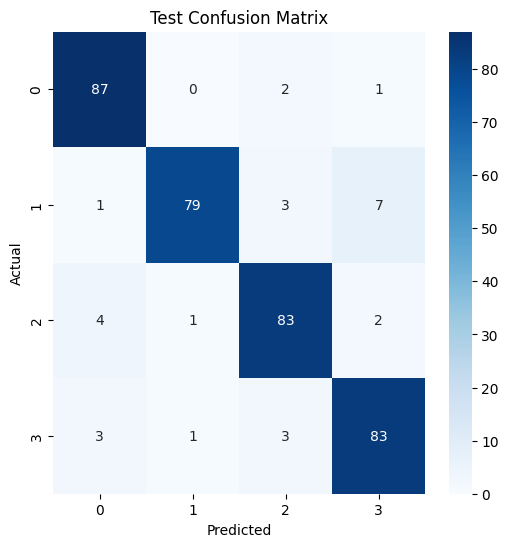

In [40]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

accuracy = accuracy_score(all_labels, all_preds)
report = classification_report(all_labels, all_preds)
cm = confusion_matrix(all_labels, all_preds)
print("Accuracy:", accuracy)
print("Classification Report:\n", report)
print("Confusion Matrix:\n", cm)

fig, ax = plt.subplots(figsize=(6,6))

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names, ax=ax)
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
ax.set_title("Test Confusion Matrix")

# Log test accuracy and confusion matrix to WandB
run.log({
    "test_accuracy": accuracy,
    "confusion_matrix": wandb.Image(fig, caption="Test Confusion Matrix")
})
plt.show()



In [41]:
run.finish()

test_accuracy,▁
train_acc,▁▅▅▆▆▇▇▇▇███████████████████████████████
train_loss,█▆▅▄▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▅▄▇▇▇▇██▁█▇███▇████▇▆██▄█▇█████▇▇█▅▇█▇██
val_loss,▇▃▁▄▂▁█▂▁▂▁▁▂▁▁▁▂▂▁▂▁▂▃▂▂▂▁▁▁▁▁▂▂▁▁▂▂▁▂▁
test_accuracy,0.92222
train_acc,0.99167
train_loss,0.02175
val_acc,0.95
val_loss,0.23759


### Setup sweep agents